In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import _tree
from sklearn.ensemble.forest import _generate_unsampled_indices


In [8]:
data = pd.read_csv('data/OnlineNewsPopularity.csv')

In [9]:
y = data[' shares'].values
X = data.drop([' shares','url',' timedelta'], axis = 1).values

In [10]:
def get_tree_oob_score(tree,X_train,y_train):
    #gets the oob score for the given tree
    indicies = _generate_unsampled_indices(tree.random_state, X_train.shape[0])
    y_true = y_train[indicies]
    y_hat_tree = tree.predict(X_train[indicies])
    rmse = np.sqrt(np.sum((y_true - y_hat_tree)**2)/len(indicies))
    return rmse

def get_score_with_x_trees(x,predictions, y_val):
    #gets the RMSE for the top x trees in the list 
    predictions = predictions[:x]
    y_hat = predictions.mean(axis = 0)
    rmse = np.sqrt(np.mean((y_val - y_hat)**2))
    return rmse


In [11]:
def get_scores(X,y):
    forest = RandomForestRegressor(n_estimators= 1000, max_depth= 4,
                                   n_jobs= -1, oob_score= True, max_features = 'sqrt',
                                   bootstrap= True, min_samples_leaf= 4 )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    forest.fit(X_train,y_train)

    y_test_hat = forest.predict(X_test)

    #rmse of the entire model
    full_model_rmse = np.sqrt( np.mean( ((y_test - y_test_hat)**2)  ) )

    
    trees = forest.estimators_
    
    random_trees = trees.copy()
    #the oob scores used to evaluate the trees 
    oob_scores = [get_tree_oob_score(tree,X_train,y_train) for tree in trees]
    

    #trees ordered by their oob scores
    tree_inds = np.argsort(oob_scores)
    ordered_trees = [trees[i] for i in tree_inds]
    
    ordered_tree_preds = np.array([tree.predict(X_test) for tree in ordered_trees])  
    
    #trees randomly ordered
    random_tree_preds = np.array([tree.predict(X_test) for tree in random_trees])
    
    #this gets the score for the best x trees for x from 1 to 1000   
    scores = []
    for x in range(1,1001):
        scores.append(get_score_with_x_trees(x,ordered_tree_preds,y_test))
    #this gets the score for a random x trees from 1 to 1000 as a null hypothesis
    random_scores = []
    for x in range(1,1001):
        random_scores.append(get_score_with_x_trees(x,random_tree_preds,y_test))

    
    return (full_model_rmse, scores ,random_scores)

In [34]:
def run_experiment(num_models, X,y):
    results = []
    t1 = time.time()
    for x in range(0,num_models):
        results.append(get_scores(X,y))
        if x%10 == 0:
            print("{}/{} done in {} seconds".format(x+1,n_models,time.time() - t1))
    return results

In [59]:
def plot_results(results, xlims, ylims,gberrors = []):
    fig, axs = plt.subplots(ncols=1, nrows = 3, figsize = (20,30))
    for total, scores, random_scores in results:
        axs[0].plot([x for x in range(1,1001)], [s  for s in scores], 'b', alpha = 0.3)
        axs[1].plot([x for x in range(1,1001)], [s  for s in random_scores], 'r', alpha = 0.3)
        axs[0].hlines(0,0,1000,color = 'g',alpha = .8)
        axs[1].hlines(0,0,1000,color = 'g',alpha = .8)

    average_ordered, average_random = [],[]    
    for x in range(0,1000):
        ordered,rand = [],[]
        for total,o_scores,r_scores in results:
            ordered.append(o_scores[x])
            rand.append(r_scores[x])
        average_ordered.append(np.mean(ordered))
        average_random.append(np.mean(rand))
    axs[0].plot([x for x in range(1,1001)],average_ordered,'b',alpha = .8)        
    axs[1].plot([x for x in range(1,1001)],average_random, 'r', alpha = 0.8)

    axs[2].plot([x for x in range(1,1001)],average_ordered,'b',alpha = .8)        
    axs[2].plot([x for x in range(1,1001)],average_random, 'r', alpha = 0.8)
    
    if gberrors:
        for gbe in gberrors:
            axs[2].hlines(gbe,0,1000,color='m',alpha = .3)
        axs[2].hlines(np.mean(gberrors),0,1000,color='m',alpha = .8)
    axs[2].hlines(0,0,1000,color = 'g',alpha = .8)
    axs[0].set_ylim(ylims[0],ylims[1])   
    axs[0].set_xlim(xlims[0],xlims[1])
    axs[1].set_ylim(ylims[0],ylims[1])    
    axs[1].set_xlim(xlims[0],xlims[1])

In [19]:
results = run_experiment(20,X,y)   

27.17058038711548
52.86729335784912
78.79142022132874
106.88051652908325
144.3772256374359
186.6091070175171
228.06371665000916
269.8035762310028
310.48039507865906
352.05652117729187
393.333801984787
421.05278301239014
447.2460927963257
472.8819544315338
498.7811176776886
524.5213260650635
550.4783737659454
576.1006367206573
601.747889995575
627.3530805110931


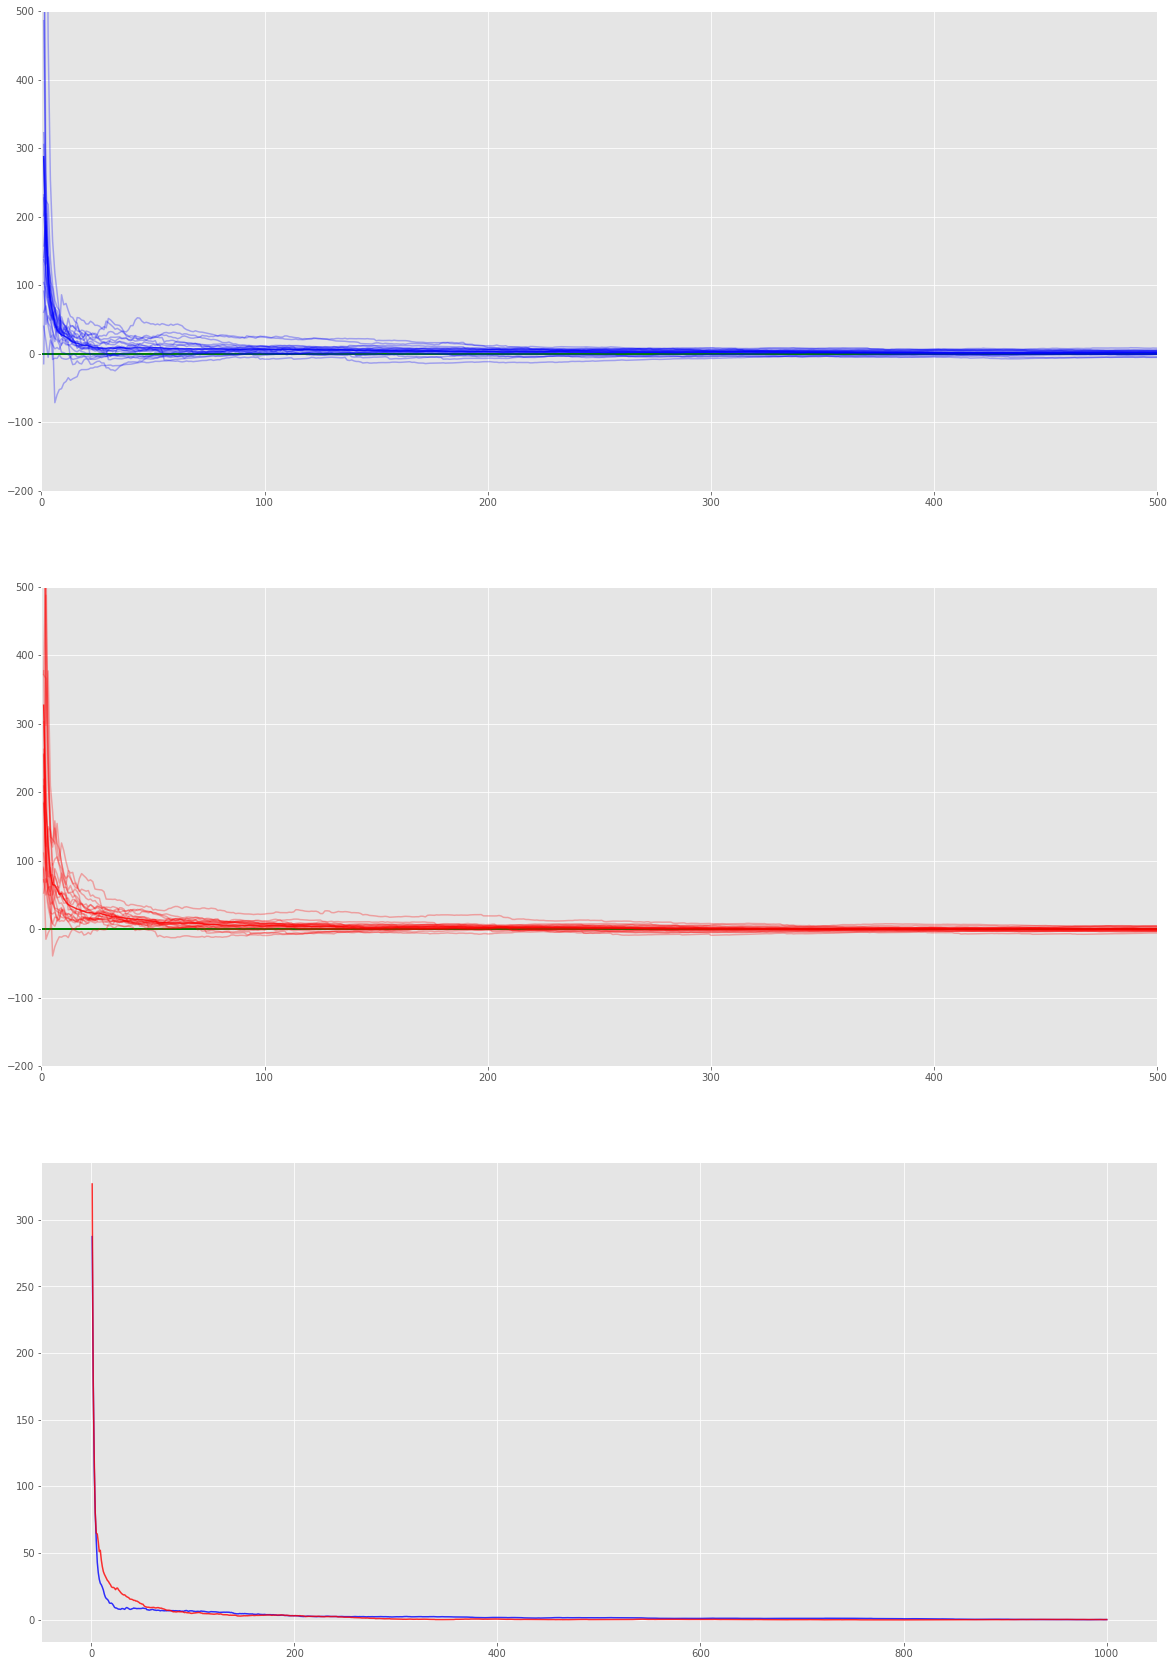

In [26]:
plot_results(results,(0,500),(-200,500))

In [4]:
data2 = pd.read_csv('data/slump_test.data.csv',index_col='No')

In [35]:
data2.shape

(103, 10)

In [7]:
X2,y2 = data2.drop('Compressive Strength (28-day)(Mpa)', axis = 1).values,data2['Compressive Strength (28-day)(Mpa)'].values

In [44]:
results2 = run_experiment(100,X2,y2)

TypeError: run_experiment() takes 3 positional arguments but 4 were given

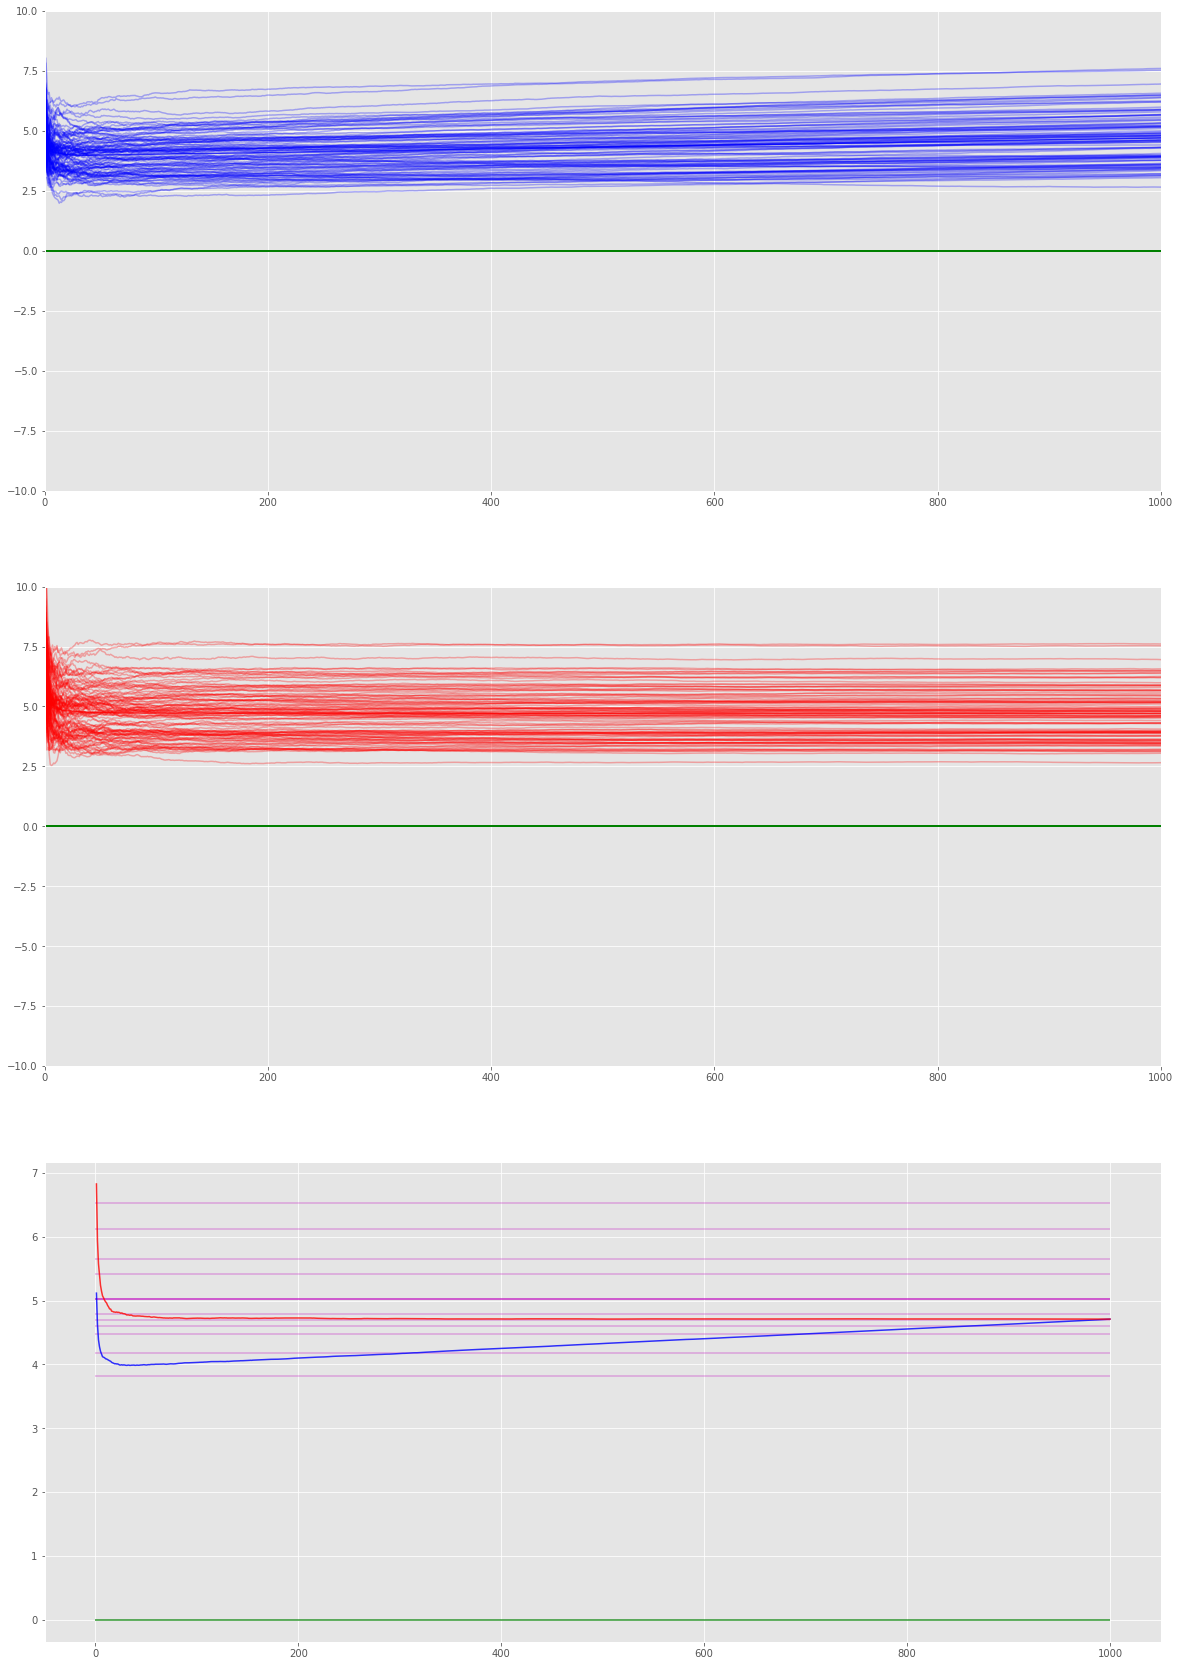

In [60]:
plot_results(results2,(0,1000),(-10,10),gberrors)

In [34]:
min_ordereds, min_randoms, compared_ordered, compared_random = [],[],[],[]
for total, scores, random_scores in results:
    min_scores = np.argmin(scores)
    min_ordereds.append(min_scores)
    compared = total - min(scores)
    compared_ordered.append(compared)
    min_random = np.argmin(random_scores)
    min_randoms.append(min_random)
    compared= total - min(random_scores)
    compared_random.append(compared)

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

In [53]:
def train_gradient_boosters(n,X,y,n_estimators = 1000):
    errors = []
    for i in range(0,n):
        gbr = GradientBoostingRegressor(n_estimators=n_estimators,learning_rate=.001,max_depth=3,subsample=.5,max_features = None)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        gbr.fit(X_train,y_train)
        y_hat = gbr.predict(X_test)
        rmse = np.sqrt( np.mean( (y_test - y_hat)**2))
        errors.append(rmse)
    return errors

In [54]:
gberrors = train_gradient_boosters(10,X2,y2)